In [1]:
import csv
import cv2
import matplotlib.pyplot as plt

In [4]:
# Load the BMP image
image_path1 = '../data/img/2000_LST.bmp'
image_path2 = '../data/img/2010_LST.bmp'
image_path3 = '../data/img/2010_LST.bmp'

# Create a CSV file to store the pixel color values
csv_path1 = '../data/csv/og/2000_LST.csv'
csv_path2 = '../data/csv/og/2010_LST.csv'
csv_path3 = '../data/csv/og/2020_LST.csv'

image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
image3 = cv2.imread(image_path3)

h,w = image1.shape[:2]
image2 = cv2.resize(image2, (w, h))
image3 = cv2.resize(image2, (w, h))
image1.shape[:2], image2.shape[:2], image3.shape[:2]

((1610, 809), (1610, 809), (1610, 809))

In [5]:
# Convert the image to grayscale
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
gray_image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)

In [5]:
for path,gray_image in zip([csv_path1,csv_path2,csv_path3],[gray_image1,gray_image2,gray_image3]):
    with open(path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Row", "Column", "Pixel Value"])  # Write header
        
        # Write pixel color values to CSV
        for row in range(h):
            for col in range(w):
                pixel_value1 = gray_image[row, col]
                writer.writerow([row, col, pixel_value1])

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [7]:
# Read the CSV files
input_df = pd.read_csv('../data/csv/2000_LST.csv')
output_df = pd.read_csv('../data/csv/2010_LST.csv')

# Extract the third column as input and output
input_data = input_df.iloc[:, 2].values
output_data = output_df.iloc[:, 2].values

In [8]:
# Preprocess the data
# (Perform any necessary preprocessing steps such as scaling or normalization here)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2)

# Reshape the data for LSTM input (assuming 1 feature per timestep)
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

In [19]:
X_test

array([[[163]],

       [[184]],

       [[124]],

       ...,

       [[156]],

       [[  0]],

       [[  0]]], dtype=int64)

In [9]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(1, 1)))  # Adjust the number of units (128) as needed
model.add(Dense(1))  # Output layer with 1 unit

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=32)  # Adjust batch_size and epochs as needed

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/2
32563/32563 [==============================] - 99s 3ms/step - loss: 2092.5232
Epoch 2/2
8141/8141 [==============================] - 13s 2ms/step


RMSE: 41.468759516252575


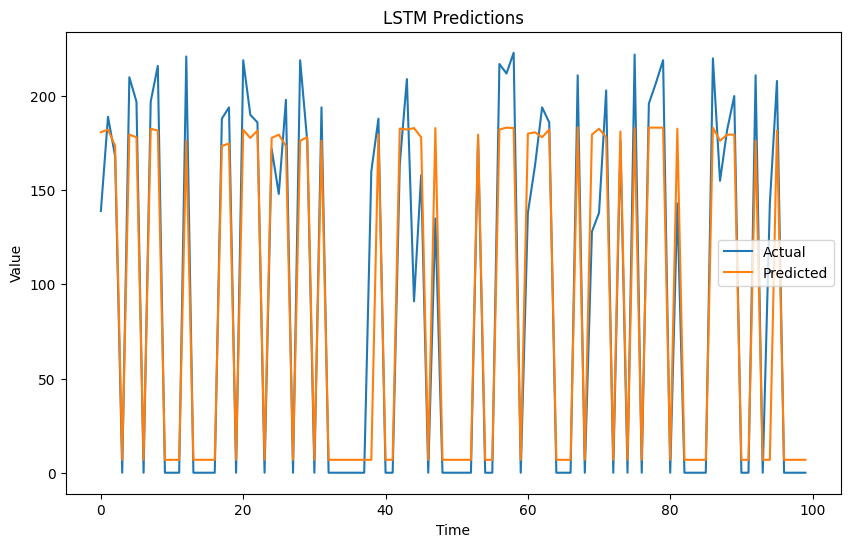

In [10]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test[0:100], label='Actual')
plt.plot(predictions[0:100], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()

In [14]:
predict_input = np.reshape(output_data, (output_data.shape[0], 1, 1))
predictions = model.predict(predict_input)


40703/40703 [==============================] - 69s 2ms/step


In [56]:
predictions[0:10]

array([6.858277, 6.858277, 6.858277, 6.858277, 6.858277, 6.858277,
       6.858277, 6.858277, 6.858277, 6.858277], dtype=float32)

In [27]:
max(predictions)

array([183.37735], dtype=float32)

In [57]:
predictions = predictions.ravel()
for i in range(len(predictions)):
    if predictions[i] >50 :
        predictions[i] -= 50

In [58]:
predict_df=output_df.copy()


In [59]:
predict_df.iloc[:, 2] = predictions
predict_df= predict_df.astype(int)
predict_df.head()

,Row,Column,Pixel Value
0,0,0,6
1,0,1,6
2,0,2,6
3,0,3,6
4,0,4,6


In [60]:
# convert the dataframe to a csv file
predict_df.to_csv('../data/csv/2020_LST_predicted.csv', index=False)

In [61]:
# contruct image from csv
import csv
import cv2
import numpy as np

# Read the CSV file containing pixel color values
csv_path = '../data/csv/2020_LST_predicted.csv'

rows = []
with open(csv_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    for row in reader:
        rows.append(row)

# Determine the dimensions of the image
max_row = max(int(row[0]) for row in rows)
max_col = max(int(row[1]) for row in rows)

# Create an empty image with grayscale dimensions
reconstructed_image = np.zeros((max_row + 1, max_col + 1), dtype=np.uint8)

# Set pixel values based on the CSV data
for row in rows:
    r, c, pixel_value = map(int, row)
    reconstructed_image[r, c] = pixel_value

# Display the reconstructed image
cv2.imshow("Reconstructed Image", reconstructed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [62]:
output_image_path = '../data/img/2020_predict.bmp'
cv2.imwrite(output_image_path, reconstructed_image)

True

In [63]:
# convert bmp image to grey scale
import cv2
import numpy as np

# Load the BMP image
image_path = '../data/img/2020_LST.bmp'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
cv2.imshow("Grayscale Image", gray_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# save the grey scale image
output_image_path = '../data/img/2020_predict_grey.bmp'
cv2.imwrite(output_image_path, gray_image)



True

In [66]:
# convert grey scale temperature map image to color temperature map image with green to red color
import cv2
import numpy as np

# Load the grayscale image
image_path = '../data/img/2020_predict.bmp'
image = cv2.imread(image_path)

# Apply the color map
color_image = cv2.applyColorMap(image, cv2.COLORMAP_HOT)

# Display the color image
cv2.imshow("Color Image", color_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
